# fdfdpy test notebook

## Import/setup

In [3]:
from fdfdpy.Fdfd import Fdfd

import matplotlib.pylab as plt
import numpy as np
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Dipole example

### Solving for the electromagnetic fields

In [4]:
# setup simulation constants
omega = 2*np.pi*200e12              # angular frequency (2pi / s)
dl = 0.02                           # grid size (units of L0, which defaults to 1e-6)

# construct a relative permittivity
eps_r = np.ones((201,201))
eps_r[35:200-35,35:65] = 2.5
NPML = [15, 15]                     # number of pml grid points on x and y borders
pol = 'Ez'                          # polarization (either 'Hz' or 'Ez')

# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Fdfd(omega, eps_r, dl, NPML, pol)

# create Jz dipole source
b = np.zeros((simulation.Nx,simulation.Ny))
b[101,101] = 1

# Solve for electromagnetic fields
(Hx,Hy,Ez) = simulation.solve_fields(b)

### Plotting results

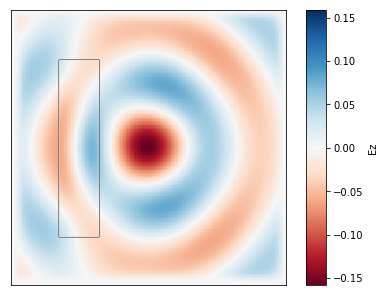

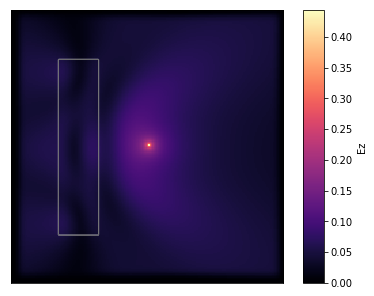

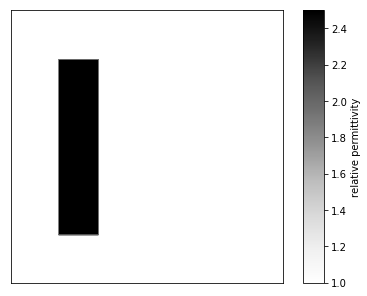

In [5]:
# plotting utilities
ax1 = simulation.plt_re(outline=True, cbar=True)
ax2 = simulation.plt_abs(outline=True, cbar=True)
ax3 = simulation.plt_eps(outline=True, cbar=True)

## Resetting Permittivity

If you want to run a new permittivity distribution with the same parameters as your previous simulation, you can run the following `Fdfd.reset_eps()` method on your `simulation` object.

This will reset `simulation.eps_r` and reconstruct a new system matrix, which can be solved again.

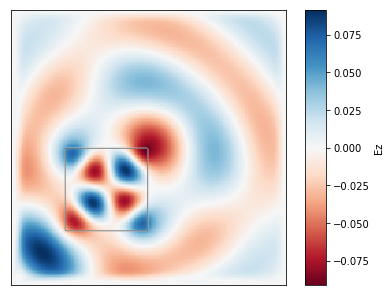

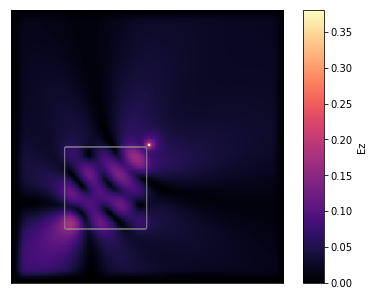

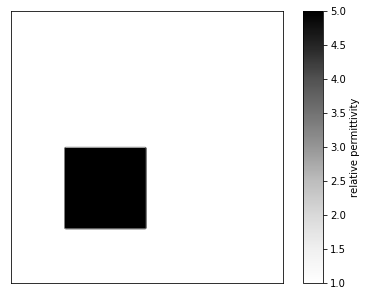

In [10]:
# construct a new permittivity
eps_new = np.ones(eps_r.shape)
eps_new[40:100, 40:100] = 5

# call simulation.reset_eps() with the new permittivity
simulation.reset_eps(eps_new)

# solve for the fields again, using the newly constructed system matrix
(Ex,Ey,Hz) = simulation.solve_fields(b)

# plot results
simulation.plt_re()
simulation.plt_abs()
simulation.plt_eps()
plt.show()

## Solving for Nonlinear Fields

fdfdpy also allows you to solve a nonlinear problem.

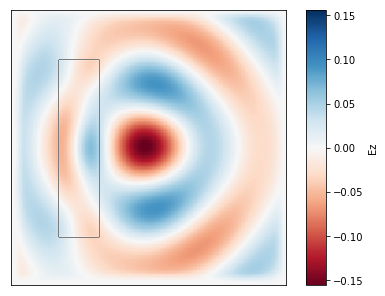

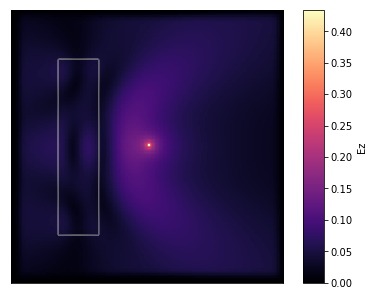

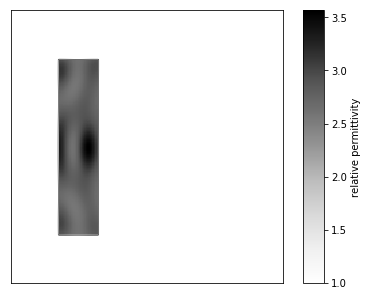

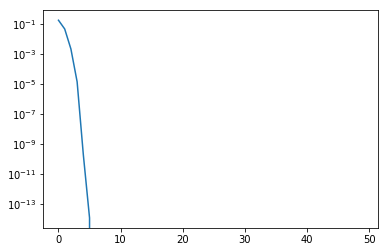

In [52]:
# define where the nonlinearity is active and its functional form, ie epsilon_r(Ez)
nl_region = eps_r > 1      # only allow nonlinear effects within the box
chi3 = 2e2                 # nonlinear susceptibility in units L0^2/V^2

# nonlinear lambda function
kerr_nonlinearity = lambda e: chi3*np.square(np.abs(e))
dkerr_de = lambda e: chi3*np.conj(e)

# solve the nonlinear fields.
simulation_nl = Fdfd(omega, eps_r, dl, NPML, pol)
(Hx_nl, Hy_nl, Ez_nl, convergence) = simulation_nl.solve_fields_nl(b, kerr_nonlinearity, nl_region,
                                          dnl_de=dkerr_de, timing=False, averaging=False,
                                          Estart=None, solver_nl='newton')

# plot results
simulation_nl.plt_re()
simulation_nl.plt_abs()
simulation_nl.plt_eps()
plt.show()
plt.plot(convergence)
plt.yscale('log')

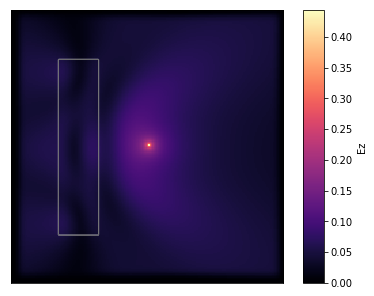

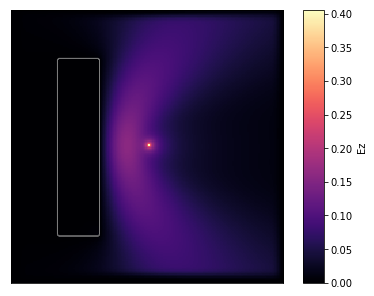

In [51]:
# compare with linear solution
simulation.plt_abs()
simulation_nl.plt_abs()